In [2]:
import numpy as np
import mplhep as hep
import matplotlib.pyplot as plt
import uproot, os, sys
import awkward as ak
# Get the notebook directory
notebook_dir = os.path.dirname(os.path.abspath("__file__"))
# Add the project root to sys.path
sys.path.append(os.path.join(notebook_dir, ".."))
from utils.branches import get_branches, truth_branches
from utils.plot import plot_data
from utils.mc_kpkm import *
from utils.constants import truthJpsiK, trigcut, dataPath, mcCorrPath, mcPath, truthpkk
from matplotlib import rcParams
import matplotlib as mpl
plt.style.use(hep.style.LHCb1)
config = {"mathtext.fontset":'stix'}
rcParams.update(config)

Welcome to JupyROOT 6.28/00


In [3]:
plt.rcParams.update({
    # Keep the font family settings for LHCb style
    "font.family": "serif",
    "font.serif": ["Times", "Computer Modern Roman", "DejaVu Serif"],
    
    # # Increase only the size-related parameters
    # "figure.figsize": (15, 10),  # Larger figure
    # "figure.dpi": 100,          # Screen display
    # "savefig.dpi": 300,         # Saved figure resolution
    
    # # # Increase font sizes while keeping LHCb style
    "font.size": 12,            # Base font size (increase from default)
    "axes.titlesize": 12,       # Title size
    "axes.labelsize": 10,       # Axis label size
    "xtick.labelsize": 12,      # X tick label size
    "ytick.labelsize": 12,      # Y tick label size
    "legend.fontsize": 12       # Legend font size
})


## Loading MC data

In [4]:
track = ["LL", "DD"]
decay = r"$B^+\to \bar{\Lambda}^0pK^+K^-$ MC"


In [5]:
import os
import uproot

tracks = ["LL", "DD"]
mcCorrPath = "/share/lazy/Mohamed/Bu2LambdaPPP/MC/DaVinciTuples/restripped.MC"

# Gather files
target_files = [
    file for file in os.listdir(mcCorrPath)
    if file.startswith(("MC16", "MC17", "MC18")) and
       "Bu2L0barPKpKm" in file and
       file.endswith(".root")
]

# Use full TTree paths
filelist = [
    f"{mcCorrPath}/{filename}:B2L0barPKpKm_{track}/DecayTree"
    for filename in target_files
    for track in tracks
]

print(f"MC Files being processed with trees {tracks}:", filelist)

# Particles
particles = ["h1", "h2", "p"]
branch_list = get_branches(particles) + [
    "p_MC15TuneV1_ProbNNp",
    "h1_MC15TuneV1_ProbNNk",
    "h2_MC15TuneV1_ProbNNk",
    "Bu_TRUEID"
]

print("MC Branches being read:", branch_list)

# Load
_mc = uproot.concatenate(filelist, branch_list, cut=trigcut  + truthpkk)


MC Files being processed with trees ['LL', 'DD']: ['/share/lazy/Mohamed/Bu2LambdaPPP/MC/DaVinciTuples/restripped.MC/MC16MDBu2L0barPKpKm.root:B2L0barPKpKm_LL/DecayTree', '/share/lazy/Mohamed/Bu2LambdaPPP/MC/DaVinciTuples/restripped.MC/MC16MDBu2L0barPKpKm.root:B2L0barPKpKm_DD/DecayTree', '/share/lazy/Mohamed/Bu2LambdaPPP/MC/DaVinciTuples/restripped.MC/MC16MUBu2L0barPKpKm.root:B2L0barPKpKm_LL/DecayTree', '/share/lazy/Mohamed/Bu2LambdaPPP/MC/DaVinciTuples/restripped.MC/MC16MUBu2L0barPKpKm.root:B2L0barPKpKm_DD/DecayTree', '/share/lazy/Mohamed/Bu2LambdaPPP/MC/DaVinciTuples/restripped.MC/MC17MDBu2L0barPKpKm.root:B2L0barPKpKm_LL/DecayTree', '/share/lazy/Mohamed/Bu2LambdaPPP/MC/DaVinciTuples/restripped.MC/MC17MDBu2L0barPKpKm.root:B2L0barPKpKm_DD/DecayTree', '/share/lazy/Mohamed/Bu2LambdaPPP/MC/DaVinciTuples/restripped.MC/MC17MUBu2L0barPKpKm.root:B2L0barPKpKm_LL/DecayTree', '/share/lazy/Mohamed/Bu2LambdaPPP/MC/DaVinciTuples/restripped.MC/MC17MUBu2L0barPKpKm.root:B2L0barPKpKm_DD/DecayTree', '/sha

In [6]:
# Lets see how many events we have
print(f"MC events: {len(_mc)}")
print(f"MC events with Bu_TRUEID > 0.5: {len(_mc[_mc['Bu_TRUEID'] > 0.5])}")

MC events: 107683
MC events with Bu_TRUEID > 0.5: 53879


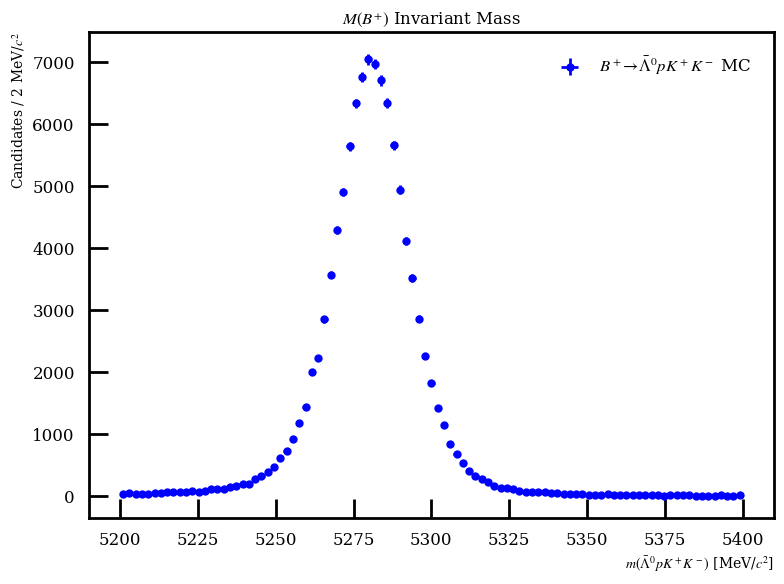

In [7]:
# plot the Bu_MM for both tracks (Bu_MM is the name of branch in both cases) and use plot_data function in one plot
fig, ax = plt.subplots(figsize=(8, 6))

# choose bins so that mass of B+ is centered
bins = np.linspace(5200, 5400, 100)
plot_data(ax=ax, data=_mc["Bu_MM"], label=decay, histstyle={'bins': bins}, color="blue")
ax.set_title(r"$M(B^{+})$ Invariant Mass")
ax.set_xlabel(r"$m(\bar{\Lambda}^0 p K^+ K^-)$ [MeV/$c^2$]")
ax.set_ylabel("Candidates / 2 MeV/$c^2$")
ax.legend()
plt.show()


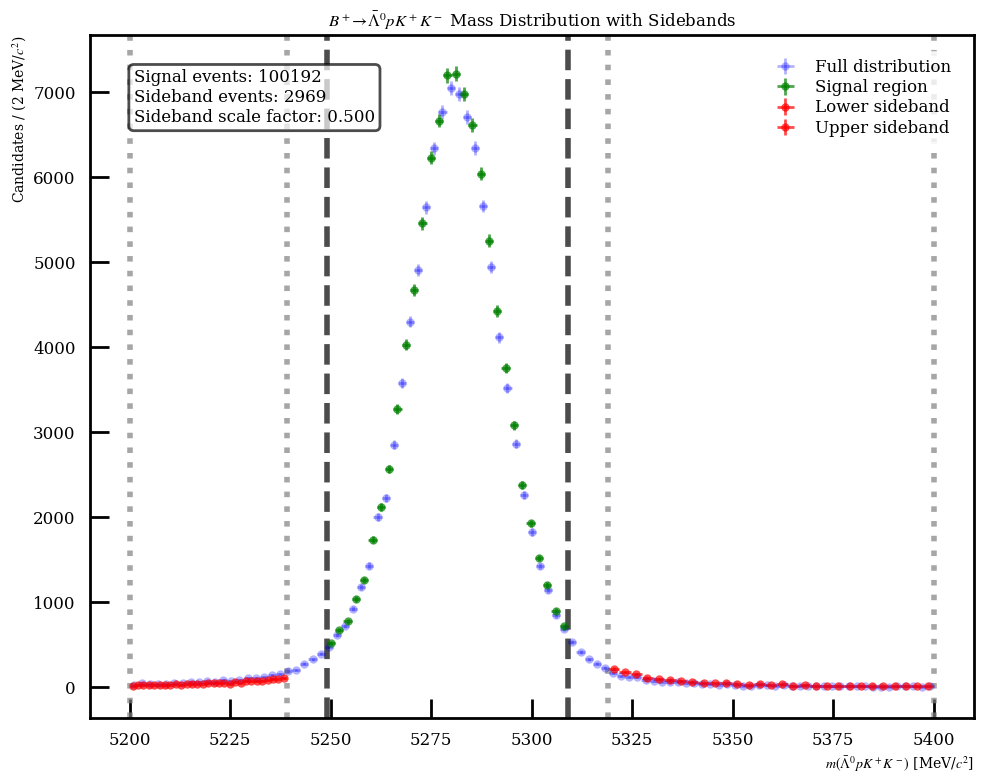

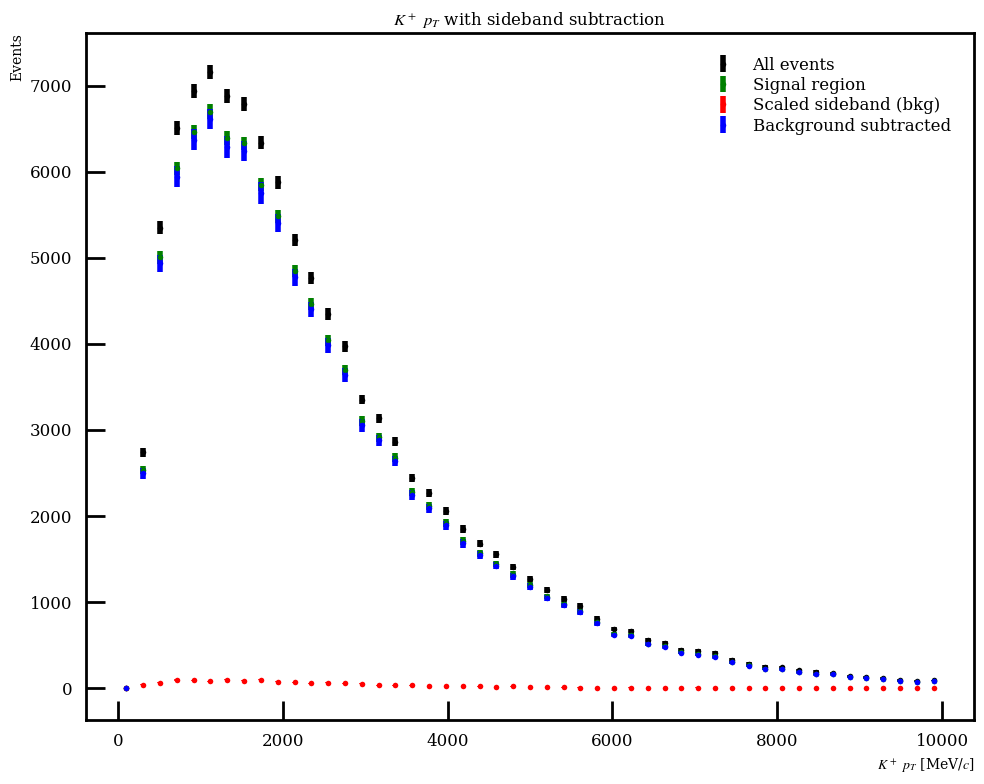

In [8]:
# Define signal and sideband regions
# For B+ meson, typical signal window is ±30 MeV around the nominal mass (5279 MeV)
B_MASS = 5279  # MeV/c^2
SIGNAL_WIDTH = 30  # MeV/c^2

# Define regions
signal_low = B_MASS - SIGNAL_WIDTH
signal_high = B_MASS + SIGNAL_WIDTH
sideband_low_min = 5200  # Lower limit for lower sideband
sideband_low_max = signal_low - 10  # 10 MeV buffer between sideband and signal
sideband_high_min = signal_high + 10  # 10 MeV buffer between signal and sideband
sideband_high_max = 5400  # Upper limit for higher sideband

# Create mask for each region
signal_mask = (_mc["Bu_MM"] >= signal_low) & (_mc["Bu_MM"] <= signal_high)
sideband_mask = (((_mc["Bu_MM"] >= sideband_low_min) & (_mc["Bu_MM"] <= sideband_low_max)) | 
                 ((_mc["Bu_MM"] >= sideband_high_min) & (_mc["Bu_MM"] <= sideband_high_max)))

# Count events in each region
n_signal = np.sum(signal_mask)
n_sideband = np.sum(sideband_mask)

# Calculate sideband scaling factor
# This accounts for the different widths of signal and sideband regions
signal_width = signal_high - signal_low
sideband_width = (sideband_low_max - sideband_low_min) + (sideband_high_max - sideband_high_min)
sideband_scale = signal_width / sideband_width

# Now plot with properly defined regions
fig, ax = plt.subplots(figsize=(10, 8))

# Full distribution
bins = np.linspace(5200, 5400, 100)
plot_data(ax=ax, data=_mc["Bu_MM"], label="Full distribution", histstyle={'bins': bins, 'alpha': 0.3}, color="blue")

# Signal region
signal_bins = np.linspace(signal_low, signal_high, 30)
plot_data(ax=ax, data=_mc["Bu_MM"][signal_mask], label="Signal region", histstyle={'bins': signal_bins, 'alpha': 0.7}, color="green")

# Sideband regions
sideband_bins_low = np.linspace(sideband_low_min, sideband_low_max, 30)
sideband_bins_high = np.linspace(sideband_high_min, sideband_high_max, 30)

# Plot lower sideband
plot_data(ax=ax, data=_mc["Bu_MM"][(_mc["Bu_MM"] >= sideband_low_min) & (_mc["Bu_MM"] <= sideband_low_max)], 
          label="Lower sideband", histstyle={'bins': sideband_bins_low, 'alpha': 0.7}, color="red")

# Plot upper sideband
plot_data(ax=ax, data=_mc["Bu_MM"][(_mc["Bu_MM"] >= sideband_high_min) & (_mc["Bu_MM"] <= sideband_high_max)], 
          label="Upper sideband", histstyle={'bins': sideband_bins_high, 'alpha': 0.7}, color="red")

# Add vertical lines to indicate region boundaries
ax.axvline(x=signal_low, color='black', linestyle='--', alpha=0.7)
ax.axvline(x=signal_high, color='black', linestyle='--', alpha=0.7)
ax.axvline(x=sideband_low_min, color='gray', linestyle=':', alpha=0.7)
ax.axvline(x=sideband_low_max, color='gray', linestyle=':', alpha=0.7)
ax.axvline(x=sideband_high_min, color='gray', linestyle=':', alpha=0.7)
ax.axvline(x=sideband_high_max, color='gray', linestyle=':', alpha=0.7)

# Add statistics text box
stats_text = (f"Signal events: {n_signal}\n"
              f"Sideband events: {n_sideband}\n"
              f"Sideband scale factor: {sideband_scale:.3f}")
ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

ax.set_title(r"$B^+ \to \bar{\Lambda}^0 p K^+ K^-$ Mass Distribution with Sidebands")
ax.set_xlabel(r"$m(\bar{\Lambda}^0 p K^+ K^-)$ [MeV/$c^2$]")
ax.set_ylabel("Candidates / (2 MeV/$c^2$)")
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Now let's create a function to use this sideband subtraction method
def estimate_background(data, variable, signal_mask, sideband_mask, sideband_scale, bins):
    """
    Estimate background in signal region using sideband subtraction.
    
    Parameters:
    -----------
    data: awkward array
        Data containing all events
    variable: str
        Name of the variable to analyze
    signal_mask: boolean array
        Mask for signal region
    sideband_mask: boolean array
        Mask for sideband regions
    sideband_scale: float
        Scale factor to apply to sideband (accounts for width differences)
    bins: array
        Bin edges for histograms
    
    Returns:
    --------
    fig, ax: matplotlib figure and axes
        Plot with background estimate
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot full distribution
    hist_all, bin_edges = np.histogram(data[variable], bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax.errorbar(bin_centers, hist_all, yerr=np.sqrt(hist_all), 
                fmt='o', label='All events', color='black', markersize=4)
    
    # Plot signal region
    hist_signal, _ = np.histogram(data[variable][signal_mask], bins=bins)
    ax.errorbar(bin_centers, hist_signal, yerr=np.sqrt(hist_signal), 
                fmt='o', label='Signal region', color='green', markersize=4)
    
    # Plot scaled sideband (background estimate)
    hist_sideband, _ = np.histogram(data[variable][sideband_mask], bins=bins)
    scaled_sideband = hist_sideband * sideband_scale
    ax.errorbar(bin_centers, scaled_sideband, yerr=np.sqrt(hist_sideband) * sideband_scale, 
                fmt='o', label='Scaled sideband (bkg)', color='red', markersize=4)
    
    # Calculate and plot signal after sideband subtraction
    background_subtracted = hist_signal - scaled_sideband
    ax.errorbar(bin_centers, background_subtracted, 
                yerr=np.sqrt(hist_signal + (scaled_sideband)**2), 
                fmt='o', label='Background subtracted', color='blue', markersize=4)
    
    ax.set_xlabel(variable)
    ax.set_ylabel("Events")
    ax.legend()
    
    return fig, ax, background_subtracted

# Example: Use this method to study a kinematic variable
if 'h1_PT' in _mc.fields:
    pt_bins = np.linspace(0, 10000, 50)  # Assuming PT is in MeV
    fig, ax, bkg_subtracted = estimate_background(
        _mc, 'h1_PT', signal_mask, sideband_mask, sideband_scale, pt_bins
    )
    ax.set_title(r"$K^+$ $p_T$ with sideband subtraction")
    ax.set_xlabel(r"$K^+$ $p_T$ [MeV/$c$]")
    plt.tight_layout()
    plt.show()

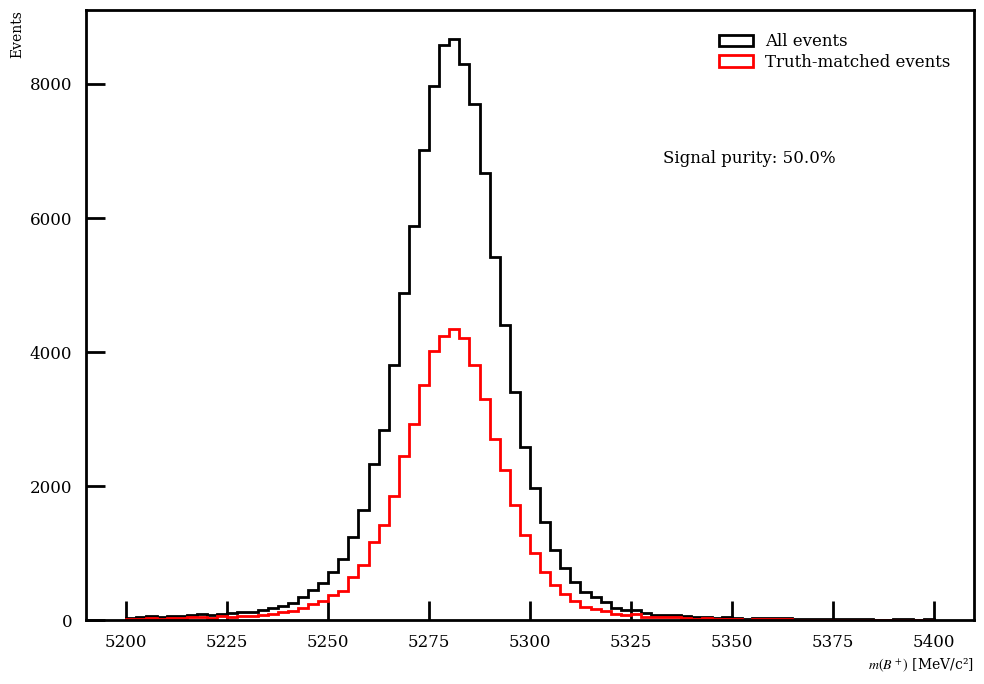

In [9]:
fig, ax = plt.subplots(figsize=(10, 7))

# All events
hist_all, bins, _ = ax.hist(_mc['Bu_MM'], bins=80, range=(5200, 5400), 
                          histtype='step', label='All events', color='black')

# Truth-matched events
truth_matched = _mc[_mc['Bu_TRUEID'] > 0]
hist_truth, _, _ = ax.hist(truth_matched['Bu_MM'], bins=bins, histtype='step', 
                         label='Truth-matched events', color='red')

# Calculate signal purity
purity = np.sum(hist_truth) / np.sum(hist_all) * 100

ax.set_xlabel(r'$m(B^+)$ [MeV/c²]')
ax.set_ylabel('Events')
ax.text(0.65, 0.75, f'Signal purity: {purity:.1f}%', transform=ax.transAxes)
plt.legend()
plt.show()

In [10]:
# Overall purity
truth_matched = _mc[_mc['Bu_TRUEID'] > 0]
purity = len(truth_matched) / len(_mc) * 100
print(f"Overall signal purity: {purity:.1f}%")

# Purity in peak region (±30 MeV around nominal mass)
peak_mask = (_mc['Bu_MM'] > 5249) & (_mc['Bu_MM'] < 5309)
peak_truth_mask = (_mc['Bu_TRUEID'] > 0) & peak_mask

peak_purity = np.sum(peak_truth_mask) / np.sum(peak_mask) * 100
print(f"Peak region signal purity: {peak_purity:.1f}%")

Overall signal purity: 50.0%
Peak region signal purity: 50.0%


In [16]:
def select(data, truth=False):
    # Ensure ccbar_M is an Awkward Array
    ccbar_M = ak.values_astype(
        np.sqrt(
            (data["L0_PE"] + data["p_PE"] + data["h2_PE"])**2 -
            (data["L0_PX"] + data["p_PX"] + data["h2_PX"])**2 -
            (data["L0_PY"] + data["p_PY"] + data["h2_PY"])**2 -
            (data["L0_PZ"] + data["p_PZ"] + data["h2_PZ"])**2
        ),
        np.float64,  # Convert explicitly to float64
    )

    # Initial selection
    selection = (data["Lp_MC15TuneV1_ProbNNp"] > 0.2) & (np.abs(data["L0_M"] - 1115.6) < 6) & (data["Bu_PT"] > 3000) 

    # Apply additional selections (avoiding in-place operations `&=`)
    # selection = selection & (np.abs(ccbar_M - 3096.9) < 30)
    # selection = selection & (np.abs(data["Bu_DTFL0_M"] - 5279) < 30)
    selection = selection & ((data["L0_ENDVERTEX_Z"] - data["Bu_ENDVERTEX_Z"]) > 20) & (data["L0_FDCHI2_ORIVX"] > 45)
    selection = selection & ((data["p_MC15TuneV1_ProbNNp"] * data["h1_MC15TuneV1_ProbNNk"] * data["h2_MC15TuneV1_ProbNNk"]) > 0.5)

    return data[selection]

# Apply selection
mc_selection = select(_mc)


In [17]:
output_dir = os.path.join(notebook_dir, "output")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Run all fitting models
print("\n=== Fitting with Gaussian + Poly2 model ===")
gp_results = extract_signal_shape_with_background(
    mc_selection,
    true_id_branch='Bu_TRUEID',
    mass_branch='Bu_MM',
    output_dir=output_dir
)

print("\n=== Fitting with Crystal Ball + Poly2 model ===")
cb_results = extract_signal_shape_cb_with_background(
    mc_selection,
    true_id_branch='Bu_TRUEID',
    mass_branch='Bu_MM',
    output_dir=output_dir
)

print("\n=== Fitting with Double Gaussian + Poly2 model ===")
dg_results = extract_signal_shape_double_gaussian_with_background(
    mc_selection,
    true_id_branch='Bu_TRUEID',
    mass_branch='Bu_MM',
    output_dir=output_dir
)

print("\n=== Fitting with Double Crystal Ball + Poly2 model ===")
dcb_results = extract_signal_shape_double_cb_with_background(
    mc_selection,
    true_id_branch='Bu_TRUEID',
    mass_branch='Bu_MM',
    output_dir=output_dir
)

# Compare all models
print("\nModel comparison by χ²/ndf:")
print(f"Gaussian + Poly2: {gp_results['chi2_ndf']:.3f}")
print(f"Crystal Ball + Poly2: {cb_results['chi2_ndf']:.3f}")
print(f"Double Gaussian + Poly2: {dg_results['chi2_ndf']:.3f}")
print(f"Double Crystal Ball + Poly2: {dcb_results['chi2_ndf']:.3f}")

# Create a dictionary of all results for further analysis
all_results = {
    "gaussian_poly2": gp_results,
    "crystal_ball_poly2": cb_results,
    "double_gaussian_poly2": dg_results,
    "double_crystal_ball_poly2": dcb_results
}

# Find best model based on χ²/ndf
best_model = min(all_results.items(), key=lambda x: x[1]['chi2_ndf'])
print(f"\nBest model: {best_model[0]} with χ²/ndf = {best_model[1]['chi2_ndf']:.3f}")

# Save all results to a JSON file for reference
with open(f"{output_dir}/model_comparison.json", 'w') as f:
    comparison = {
        model_name: {"chi2_ndf": params["chi2_ndf"]} 
        for model_name, params in all_results.items()
    }
    json.dump(comparison, f, indent=4)


=== Fitting with Gaussian + Poly2 model ===
Extracting shape using Gaussian+Poly2 model
Number of events: 70462
Gaussian+Poly2 shape parameters:
  Mean = 5280.72 ± 0.05 MeV/c²
  Sigma = 11.83 ± 0.04 MeV/c²
  Signal yield = 64992 ± 277
  Background yield = 4706 ± 127
  Signal fraction = 93.2%
  χ²/ndf = 5.974

=== Fitting with Crystal Ball + Poly2 model ===
Extracting shape using Crystal Ball + Poly2 model
Number of events: 70462
Crystal Ball + Poly2 shape parameters:
  Mean = 5280.83 ± 0.05 MeV/c²
  Sigma = 11.77 ± 0.05 MeV/c²
  Alpha = 1.90 ± 0.03
  n = 10.00 ± 0.37
  Signal yield = 65963 ± 289
  Background yield = 3734 ± 146
  Signal fraction = 94.6%
  χ²/ndf = 5.083

=== Fitting with Double Gaussian + Poly2 model ===
Extracting shape using Double Gaussian + Poly2 model
Number of events: 70462
Double Gaussian + Poly2 shape parameters:
  Mean = 5280.67 ± 0.06 MeV/c²
  Sigma1 = 9.36 ± 2.62 MeV/c²
  Sigma2 = 15.50 ± 16.38 MeV/c²
  Fraction = 0.55 ± 0.74
  Effective Sigma = 12.53 ± 6.45

Info in <TCanvas::Print>: pdf file /data/home/melashri/analyses/bu2lambdapKK/notebooks/output/b_mass_shape_MC_Gauss_Pol2.pdf has been created
Info in <TCanvas::Print>: png file /data/home/melashri/analyses/bu2lambdapKK/notebooks/output/b_mass_shape_MC_CB_Pol2.png has been created
Info in <TCanvas::Print>: pdf file /data/home/melashri/analyses/bu2lambdapKK/notebooks/output/b_mass_shape_MC_CB_Pol2.pdf has been created
Info in <TCanvas::Print>: pdf file /data/home/melashri/analyses/bu2lambdapKK/notebooks/output/b_mass_shape_MC_DoubleGauss_Pol2.pdf has been created
Info in <TCanvas::Print>: pdf file /data/home/melashri/analyses/bu2lambdapKK/notebooks/output/b_mass_shape_MC_DoubleCB_Pol2.pdf has been created
